# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [ ]:
# @title Install dependencies and import packages
!pip install nilearn --quiet
from nilearn import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

#nilearn - neuroimaging tailored library
from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting

#sklearn - basic ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

# PyTorch - for NN models
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam


#scipy- statistical analysis tools
from scipy.stats import ttest_1samp
from scipy import interp

import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#sklearn - basic ML tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.3 MB/s eta 0:00:00


In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'
# TIP: look inside the data folders for more fine-graned conditions

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

> For a detailed description of the tasks have a look pages 45-54 of the [HCP reference manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

# Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

# Help functions

We provide two helper functions: one for loading the time series from a single suject and a single run, and one for loading an EV file for each task.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts


def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    cond = 'mental' if cond=='ment' else 'rnd'
    ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)
  return frames_list

def load_resp(subject, experiment, run):
  frames_list = []
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  conds = ['mental', 'other']
  for cond in conds:
    resp_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}_resp.txt"
    resp_array = np.loadtxt(resp_file, ndmin=2, unpack=True)
    if len(resp_array)<=1:
      frames_list = 0
      return frames_list
    else:
      resp = dict(zip(["onset", "duration", "amplitude"], resp_array))
      # Determine when trial starts, rounded down
      start = np.floor(resp["onset"] / TR).astype(int)
      # Use trial duration to determine how many frames to include for trial
      duration = np.ceil(resp["duration"] / TR).astype(int)
      # Take the range of frames that correspond to this specific trial
      frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
      frames_list.append(frames)
  return frames_list

# Load in data for one run

In [ ]:
my_exp = 'SOCIAL'
my_subj = subjects[10]
my_run = 0

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)

(360, 274)


Now in order to understand how to model these data, we need to relate the time series to the experimental manipulation. This is described by the EV files. Let us load the EVs for this experiment.

In [ ]:
evs = load_evs(subject=my_subj, experiment=my_exp, run=my_run)
resps = load_resp(subject=my_subj, experiment=my_exp, run=my_run)

In [ ]:
# Function that selects a specific region
def region_frames(data, regions):
  region_idx = []
  region_names = region_info['name']
  for idx, key in enumerate(region_names):
    if key in regions:
      region_idx.append(idx)
  data_regions = data[region_idx, :]
  return data_regions


#loading trials from a subject
def load_sub_trials(subject, experiment, regions):
  runs = [0, 1]
  all_trials, cond_labels = [], []
  for run in runs:
    # Load neural data and behavioral responses
    data = load_single_timeseries(subject=subject,
                                experiment=experiment,
                                run=run,
                                remove_mean=True)
    roi_data = region_frames(data, regions)
    resps = load_resp(subject=subject, experiment=experiment, run=run)
    if resps == 0:
      continue
    else:
      # Loop through all trials in a single run
      for i, cond in enumerate(resps):
        cond_label = 1 if i==0 else 0 # Set labels: 1 for "ment", 0 for "other"
        for j, trial_idx in enumerate(cond):
          trial_data = roi_data[:, trial_idx]
          all_trials.append(trial_data)
          cond_labels.append(cond_label)

        sub_data = np.stack(all_trials)
  return sub_data, cond_labels

In [ ]:
all_subjects = []
for sub in subjects:
  run_1 = load_resp(sub, my_exp, 0)
  run_2 = load_resp(sub, my_exp, 1)
  if run_1!=0 and run_2!=0:
    # sub_data, _ = load_sub_trials(sub, my_exp)
    all_subjects.append(sub)
    # if sub_data.shape!=(10, 6, 32):

In [ ]:
def get_train_test(X, y, i, verbose=False):
  '''
  split to train and test sets, and reshape data
  X data
  y labels
  i random state
  '''
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

  # Reshapes data to 4D for Hierarchical RNN.
  t_shape=X.shape[2]
  RSN_shape=X.shape[1]

  X_train = np.reshape(X_train, (len(X_train),  RSN_shape, t_shape))
  X_test = np.reshape(X_test, (len(X_test),  RSN_shape, t_shape))

  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')

  if verbose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

  return X_train, X_test, y_train, y_test

In [ ]:
#regions = ['R_TPOJ1','R_TPOJ2','R_TPOJ3','L_TPOJ1','L_TPOJ2','L_TPOJ3']
regions = ['R_A1','R_STGa','R_A5','L_A1','L_STGa','L_A5']
data, labels = [], []
N = len(subjects)
for sub in range(0, N):
  sub_name = subjects[sub]
  sub_data, cond_labels = load_sub_trials(subject=sub_name, experiment='SOCIAL', regions = regions)
  data.append(sub_data)
  labels.append(cond_labels)
data = np.concatenate(data)
labels = np.concatenate(labels)


In [ ]:
X_train, X_test, y_train, y_test = get_train_test(data, labels, 8)

# Convert numpy arrays to PyTorch tensors and rearrange dimensions
X_train_torch = torch.from_numpy(X_train).float().permute(0, 2, 1)  # transpose the last two dimensions
y_train_torch = torch.from_numpy(y_train).long()
X_test_torch = torch.from_numpy(X_test).float().permute(0, 2, 1)  # transpose the last two dimensions
y_test_torch = torch.from_numpy(y_test).long()

# Create Tensor datasets
train_data = TensorDataset(X_train_torch, y_train_torch)
test_data = TensorDataset(X_test_torch, y_test_torch)

# Define a batch size
batch_size = 32

# Create DataLoaders
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_shape):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_shape, hidden_size=23, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.6)
        self.lstm2 = nn.LSTM(input_size=23, hidden_size=10, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.6)
        self.lstm3 = nn.LSTM(input_size=10, hidden_size=5, num_layers=1, batch_first=True)
        self.dropout3 = nn.Dropout(0.6)
        self.fc = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x[:, -1, :]  # select output of the last sequence
        x = self.fc(x)
        x = self.sigmoid(x)
        return x.squeeze()

t_shape = np.array(data).shape[2]
RSN_shape = np.array(data).shape[1]
input_shape = RSN_shape

model = LSTMModel(input_shape)
print(model)

# Check if a GPU is available and if not, use a CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Then send the model to the chosen device
model.to(device)

LSTMModel(
  (lstm1): LSTM(6, 23, batch_first=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (lstm2): LSTM(23, 10, batch_first=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (lstm3): LSTM(10, 5, batch_first=True)
  (dropout3): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


LSTMModel(
  (lstm1): LSTM(6, 23, batch_first=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (lstm2): LSTM(23, 10, batch_first=True)
  (dropout2): Dropout(p=0.6, inplace=False)
  (lstm3): LSTM(10, 5, batch_first=True)
  (dropout3): Dropout(p=0.6, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

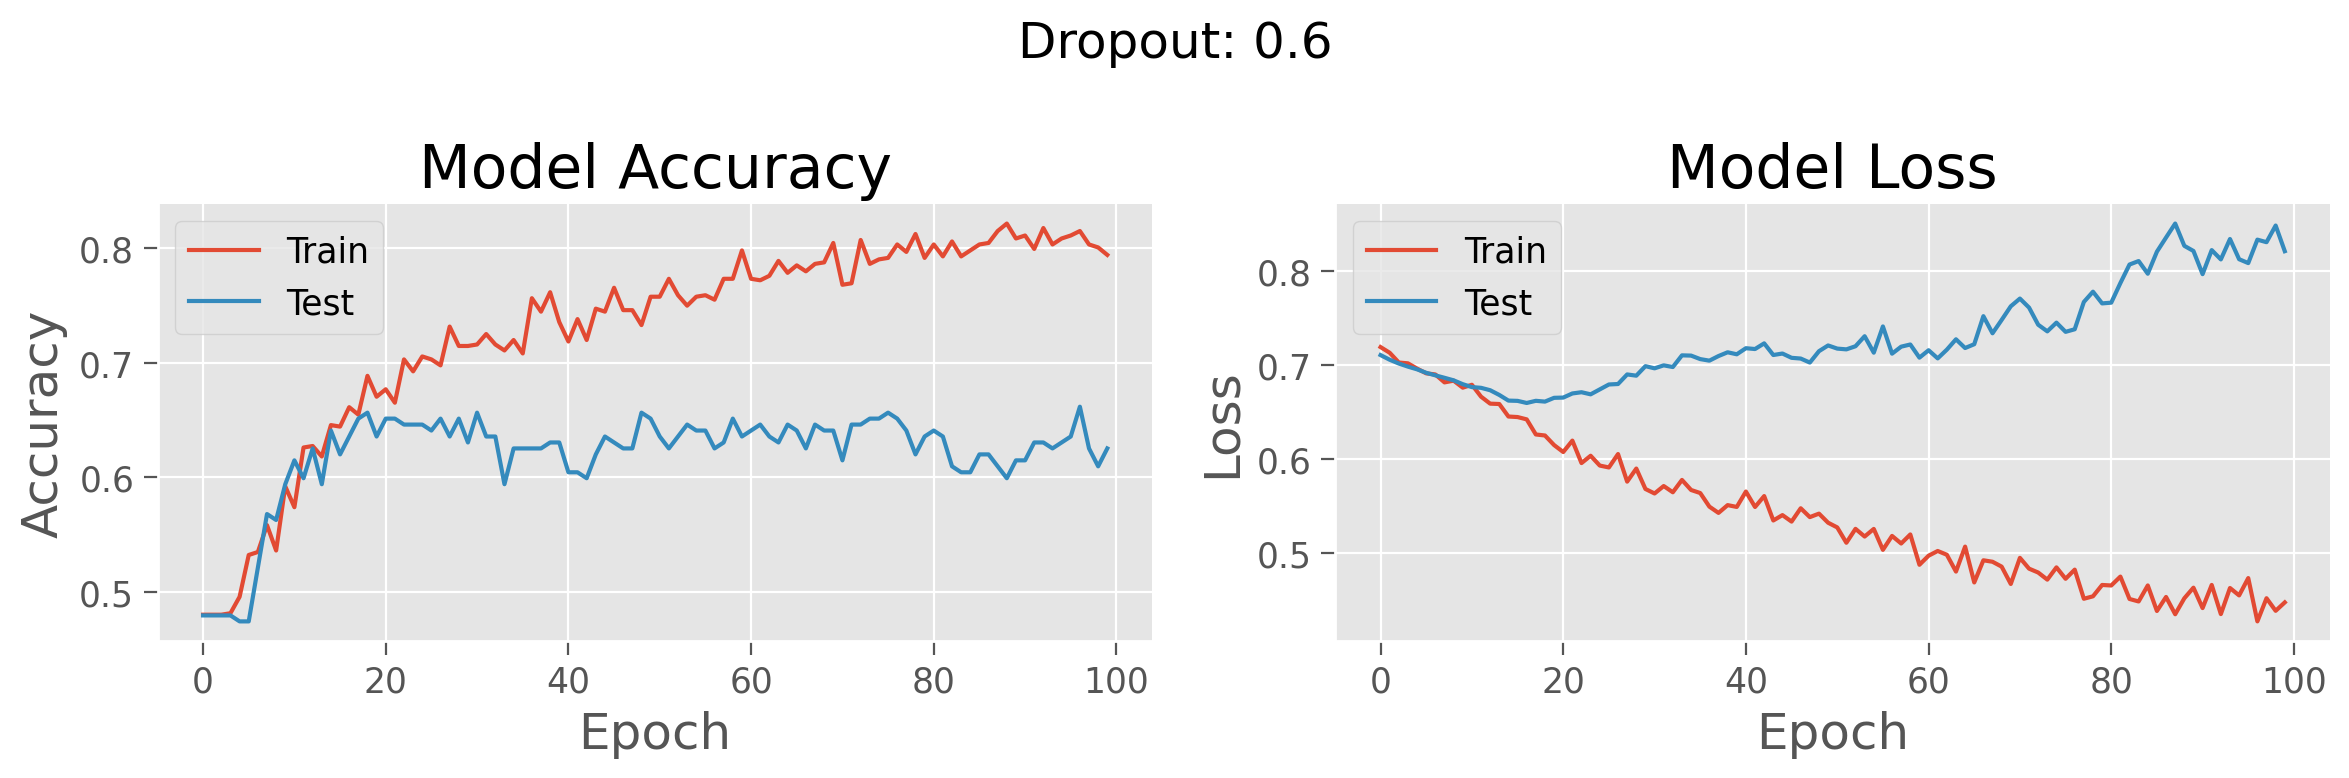

In [ ]:
# @title Dropout rate is 0.6
#Dropout rate is 0.6. No early stopping here:

# Define the model
model = LSTMModel(RSN_shape)

# Define the loss function (criterion) and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Now we can start the training loop.

# Define the number of epochs
epochs = 100

# Store the training loss and accuracy for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []  # added for test data

# Move the model to the device (GPU or CPU)
model.to(device)

for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        preds = (outputs > 0.5).float()  # convert outputs to binary 0/1 predictions
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Test phase
    model.eval()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        preds = (outputs > 0.5).float()
        loss = criterion(outputs, labels.float())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)

# Plot the training and test accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')  # added for test data
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')  # added for test data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.suptitle('Dropout: 0.6')  # Add overarching title

plt.tight_layout()
plt.show()


Early stopping!


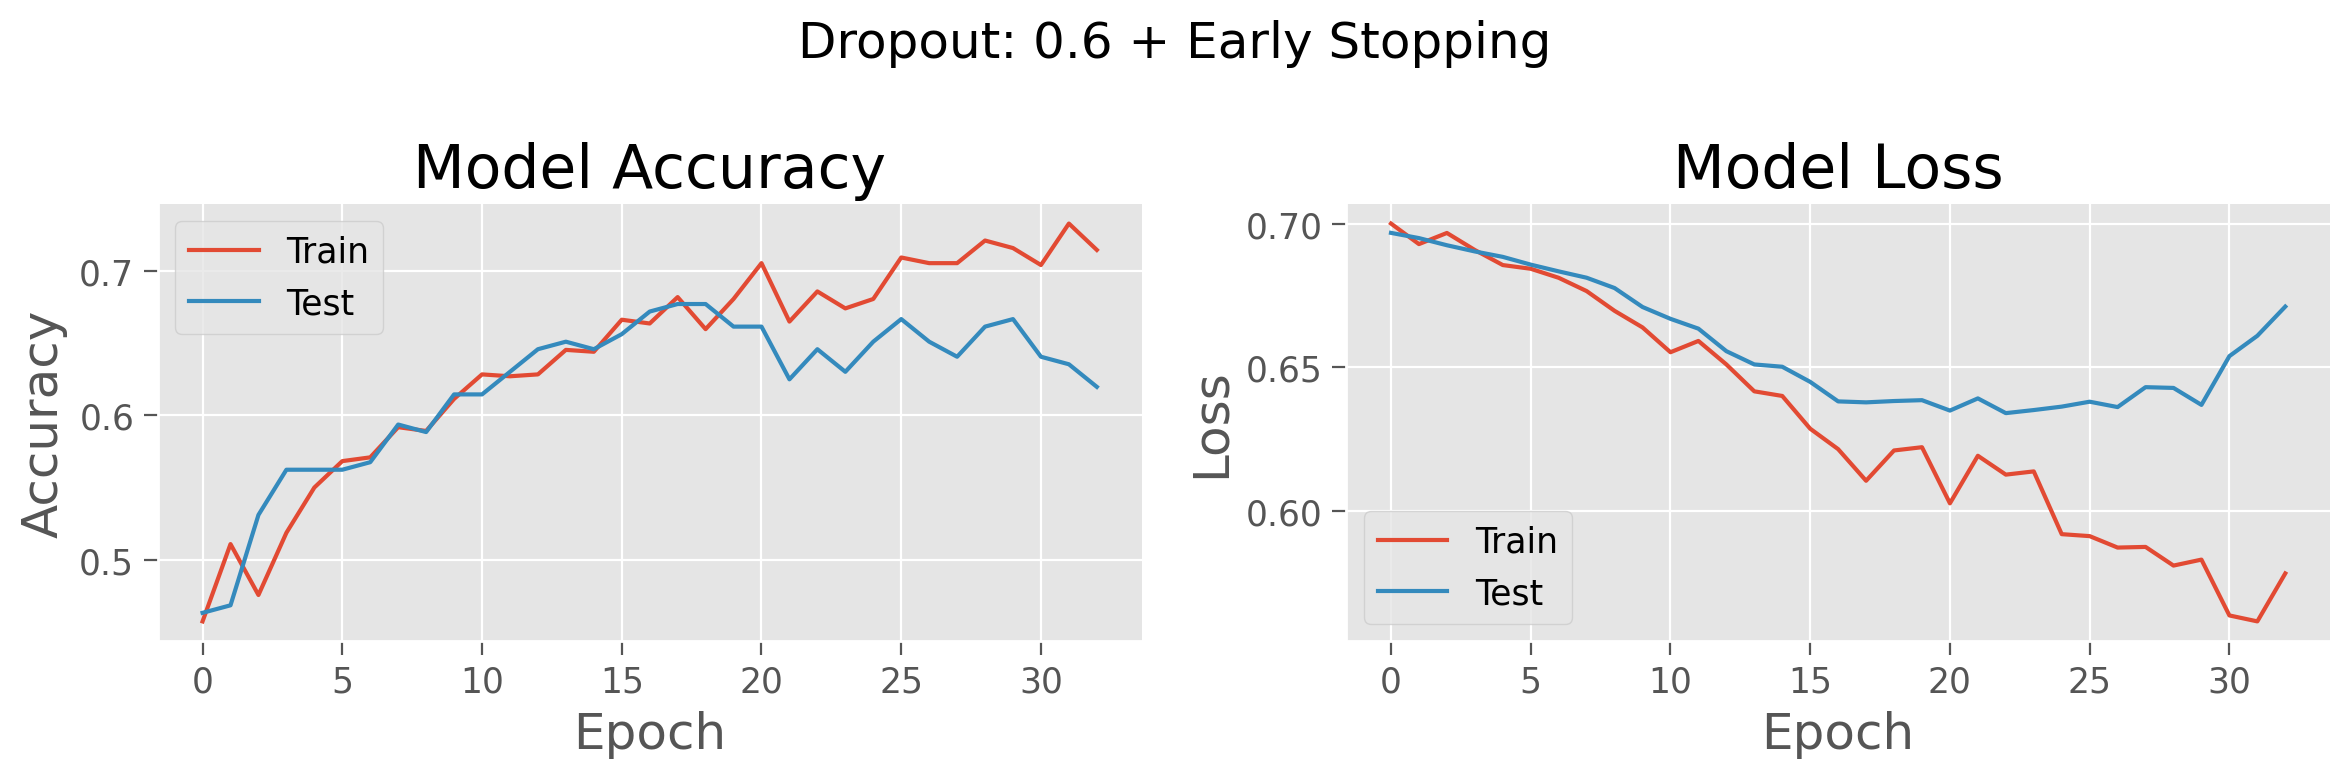

In [ ]:
# @title Dropout rate at 0.6 and Early Stopping with a patience of 10
#Dropout rate at 0.6 and Early Stopping with a patience of 10
# Define the model
model = LSTMModel(RSN_shape)

# Define the loss function (criterion) and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Now we can start the training loop.

# Define the number of epochs
epochs = 100

# Define patience
patience = 10

# Store the training loss and accuracy for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []  # added for test data

# Additional variables for early stopping
best_loss = np.inf
epochs_no_improve = 0

# Move the model to the device (GPU or CPU)
model.to(device)

for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        preds = (outputs > 0.5).float()  # convert outputs to binary 0/1 predictions
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Test phase
    model.eval()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        preds = (outputs > 0.5).float()
        loss = criterion(outputs, labels.float())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        # Save the model state
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best state and break the loop
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Plot the training and test accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')  # added for test data
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')  # added for test data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.suptitle('Dropout: 0.6 + Early Stopping')  # Add overarching title

plt.tight_layout()
plt.show()

Early stopping!


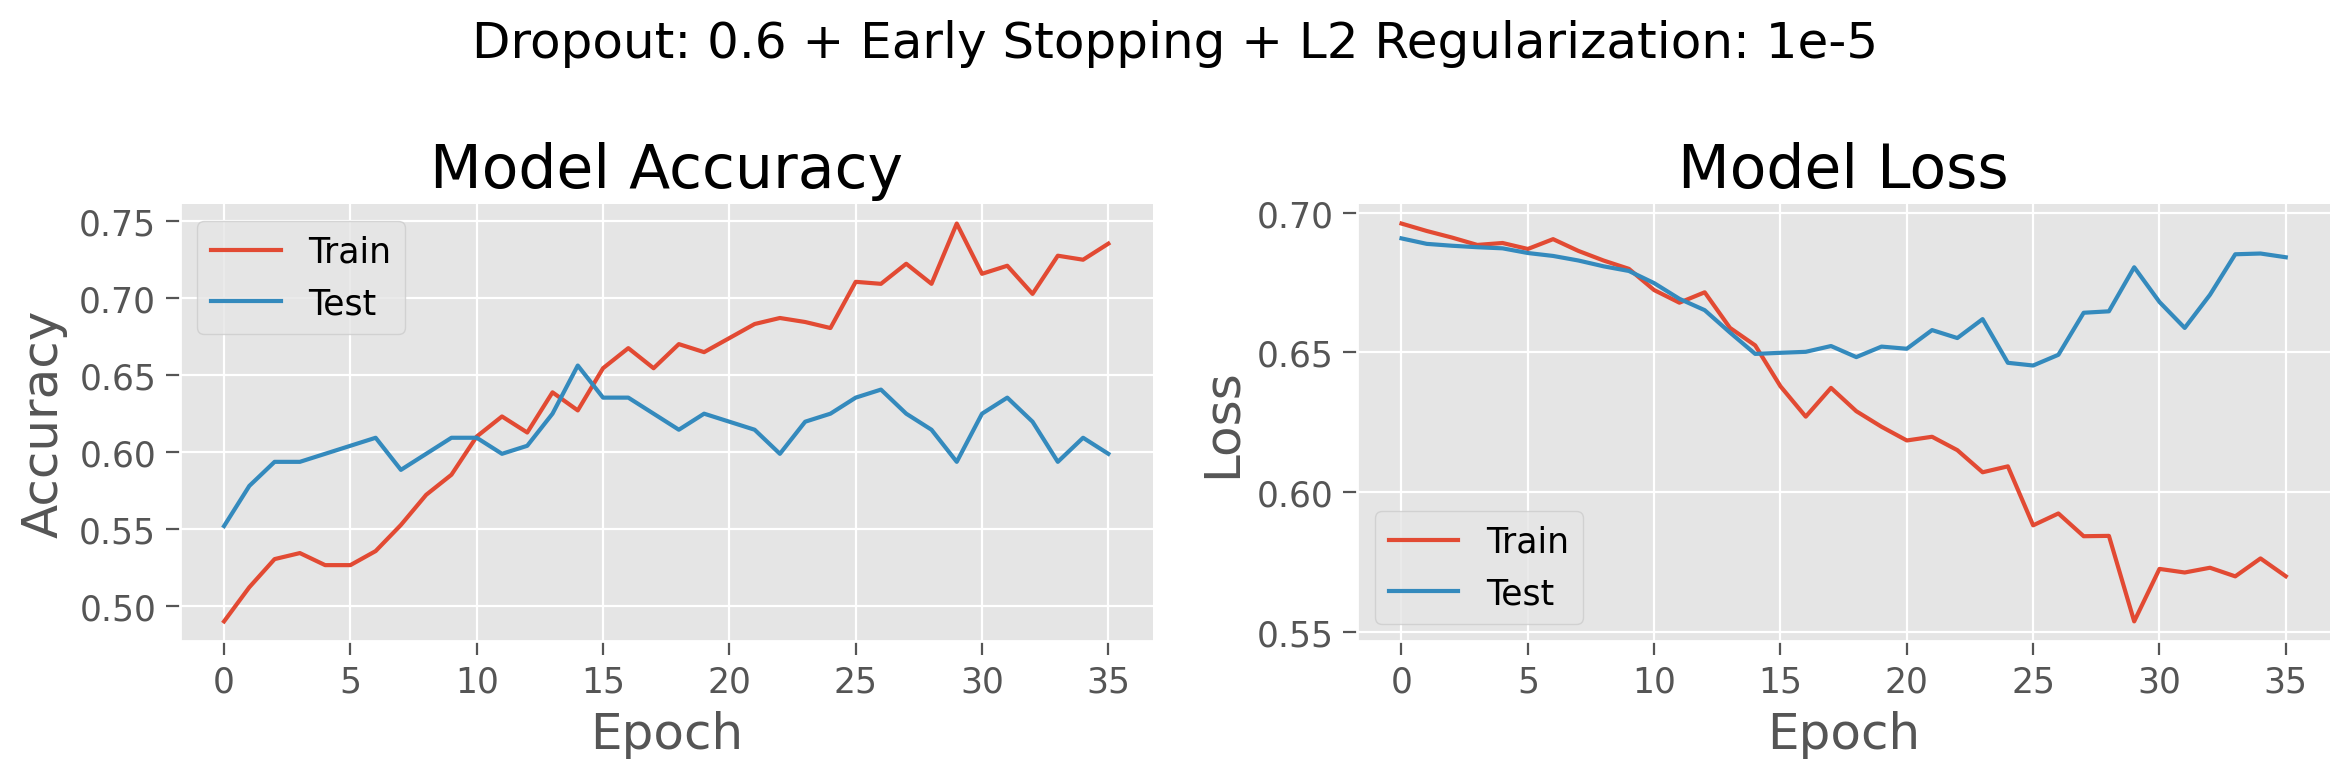

In [ ]:
# @title Dropout rate at 0.6 and Early Stopping with a patience of 10 + L2 regularization (weight decay = 0.00001)

#Dropout rate at 0.6 and Early Stopping with a patience of 10 + L2 regularization (weight decay = 0.00001)
# Define the model
model = LSTMModel(RSN_shape)

# Define the loss function (criterion) and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # added weight_decay for L2 regularization

# Now we can start the training loop.

# Define the number of epochs
epochs = 100

# Define patience
patience = 10

# Store the training loss and accuracy for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []  # added for test data

# Additional variables for early stopping
best_loss = np.inf
epochs_no_improve = 0

# Move the model to the device (GPU or CPU)
model.to(device)

for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        preds = (outputs > 0.5).float()  # convert outputs to binary 0/1 predictions
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Test phase
    model.eval()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        preds = (outputs > 0.5).float()
        loss = criterion(outputs, labels.float())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        # Save the model state
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best state and break the loop
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Plot the training and test accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')  # added for test data
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')  # added for test data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.suptitle('Dropout: 0.6 + Early Stopping + L2 Regularization: 1e-5')  # Add overarching title

plt.tight_layout()
plt.show()



Early stopping!


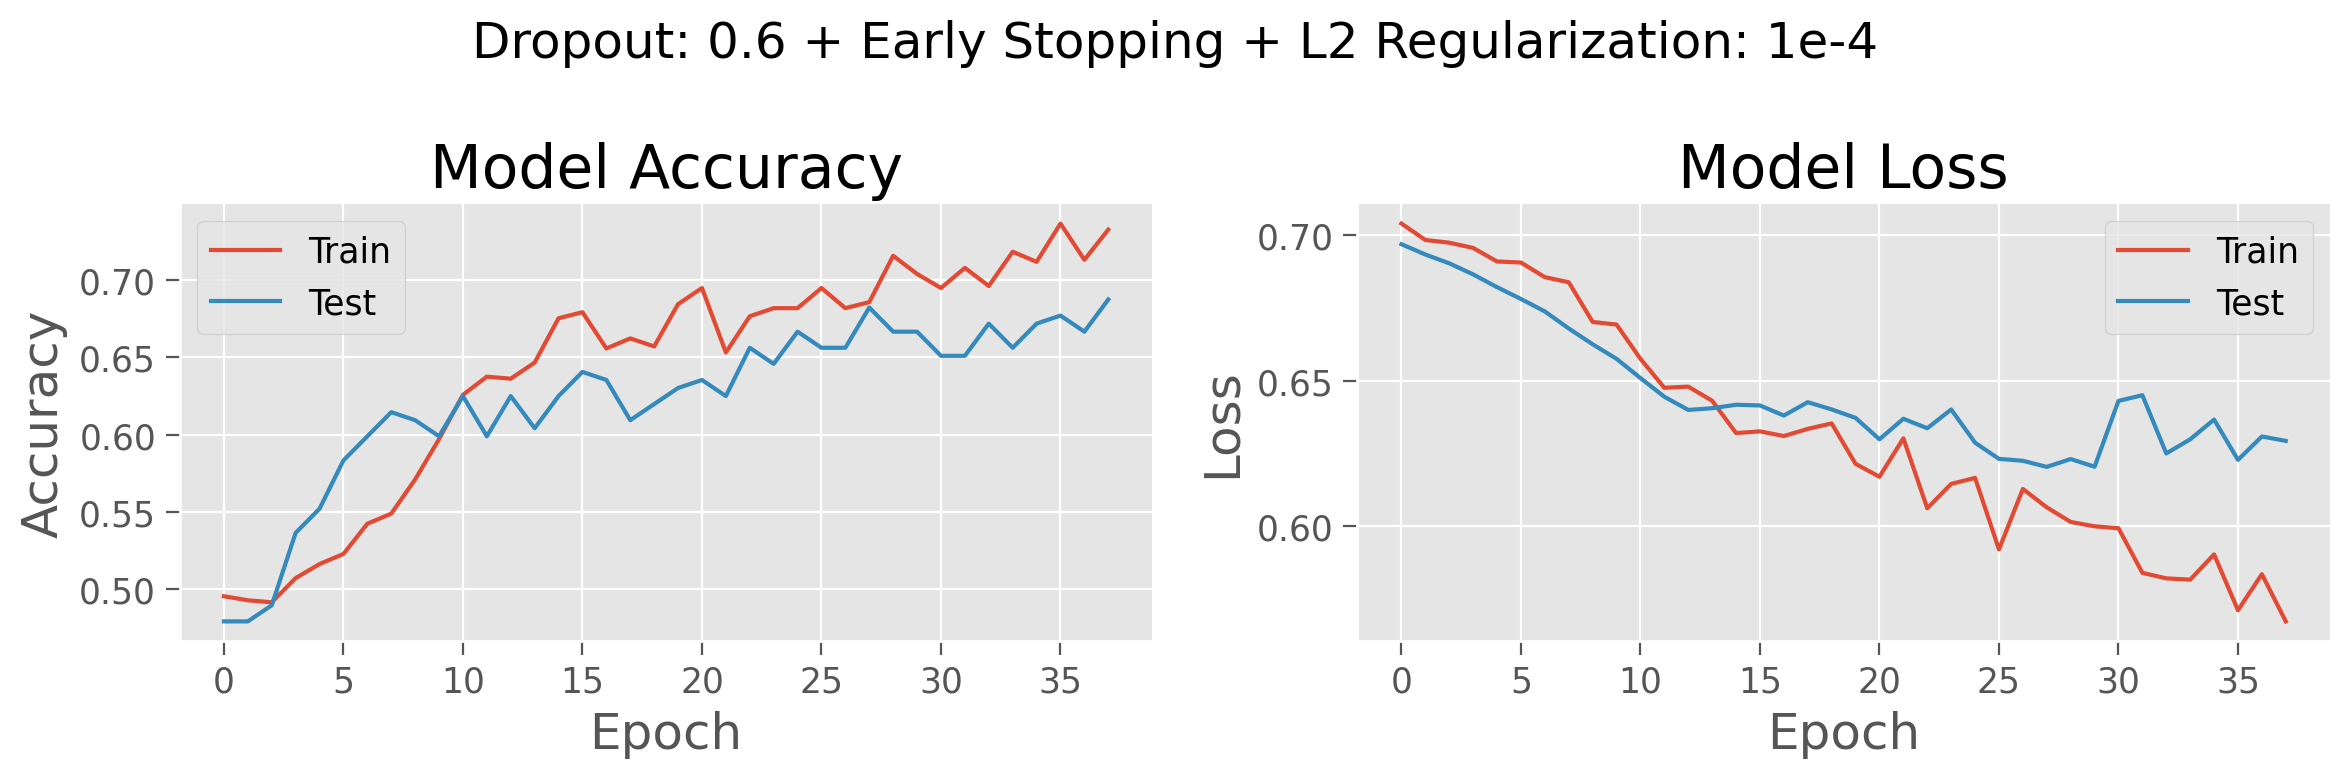

In [ ]:
# @title Dropout rate at 0.6 and Early Stopping with a patience of 10 + L2 regularization (weight decay = 0.0001)

#Dropout rate at 0.6 and Early Stopping with a patience of 10 + L2 regularization (weight decay = 0.0001)
# Define the model
model = LSTMModel(RSN_shape)

# Define the loss function (criterion) and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # added weight_decay for L2 regularization

# Now we can start the training loop.

# Define the number of epochs
epochs = 100

# Define patience
patience = 10

# Store the training loss and accuracy for plotting
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []  # added for test data

# Additional variables for early stopping
best_loss = np.inf
epochs_no_improve = 0

# Move the model to the device (GPU or CPU)
model.to(device)

for epoch in range(epochs):
    # Set the model to training mode
    model.train()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        preds = (outputs > 0.5).float()  # convert outputs to binary 0/1 predictions
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Test phase
    model.eval()
    running_loss, running_corrects = 0.0, 0.0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        preds = (outputs > 0.5).float()
        loss = criterion(outputs, labels.float())

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = running_corrects.double() / len(test_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_acc)

    # Early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        epochs_no_improve = 0
        # Save the model state
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best state and break the loop
            model.load_state_dict(torch.load('best_model.pt'))
            break

# Plot the training and test accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')  # added for test data
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')  # added for test data
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.suptitle('Dropout: 0.6 + Early Stopping + L2 Regularization: 1e-4')  # Add overarching title

plt.tight_layout()
plt.show()



In [ ]:
!pip install torchviz

from torchviz import make_dot

# Create a random tensor of the correct size to simulate input data
# Here, you'll need to replace the dimensions with the dimensions of your actual input
dummy_input = torch.randn(1, t_shape, RSN_shape)

# Pass the dummy input through the model
output = model(dummy_input)

# Use torchviz to generate the plot
dot = make_dot(output, params=dict(list(model.named_parameters())))

# Display the plot
dot.view()


  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=96783e0319ba13c1d28fad29a0b53ffba594af550e919feaa68afc89ac329ff0
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


'Digraph.gv.pdf'

In [ ]:
import numpy as np

def temporal_shift(data, shift):
    """
    Shifts the last dimension of the input array by 'shift' steps.
    Elements that are shifted beyond the last position are discarded.
    The resulting array will have the same shape as the input array.

    Args:
    data (np.array): input array with shape (n_trials, n_regions, n_timepoints)
    shift (int): the number of steps to shift the last dimension of the array.

    Returns:
    np.array: the shifted array.
    """
    return np.roll(data, shift=shift, axis=-1)

# Example usage:
data =  np.random.rand(10, 6, 32) # replace w/ actual data
shifted_data = temporal_shift(data, shift=1)


The scipy.interpolate.interp1d function creates a function based on a 1-dimensional interpolation of a dataset. In simpler terms, it creates a function that 'connects the dots' of your data points and allows you to estimate what the values would be at points that are not in your original dataset.

When you apply interp1d to your activation data, the function is considering each set of 32 activation levels as a series of points in 1-dimensional space. It's creating a continuous function that fits those points.

When you then use this function to generate data at new indices (in your case, upscaling from 32 time points to 64), it's estimating what the activation levels would be at those points, based on the continuous function it created.

In essence, this is a way of increasing the resolution of your data - you're creating a higher-resolution version of your original data where the added points are estimates based on the existing points. The type of estimates (linear, nearest, cubic, etc.) can be controlled with the kind parameter of the interp1d function. By default, it performs linear interpolation.

In [ ]:
import numpy as np
from scipy import interpolate

def interpolate_data(data, target_size):
    # Get the current size of the data
    original_size = data.shape[2]

    # Create an interpolation function
    f = interpolate.interp1d(np.arange(original_size), data, axis=2)

    # Create an array of indices for the target size
    new_indices = np.linspace(0, original_size-1, target_size)

    # Apply the interpolation function
    return f(new_indices)

# Create an example input array with shape (10, 6, 32) filled with random numbers
data = np.random.rand(10, 6, 32)

# Interpolate the data to a target size of 64 time points
interpolated_data = interpolate_data(data, 64)

print(interpolated_data.shape)  # This should print (10, 6, 64)


(10, 6, 64)
